In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# read in all the words
words = open('poops.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [36]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr.shape, Ytr.shape # dataset
g = torch.Generator().manual_seed(2147483647) # for reproducibility

torch.Size([288, 3]) torch.Size([288])
torch.Size([33, 3]) torch.Size([33])
torch.Size([51, 3]) torch.Size([51])


In [37]:
input_len = 27
input_n = 5
hidden_n_count = 100
steps = 200_000
C = torch.randn((input_len, input_n), generator=g)
W1 = torch.randn((input_n*3, hidden_n_count), generator=g)
b1 = torch.randn(hidden_n_count, generator=g)
W2 = torch.randn((hidden_n_count, input_len), generator=g)
b2 = torch.randn(input_len, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters) # number of parameters in total

4462

In [39]:
for p in parameters:
    p.requires_grad = True
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
lri = []
lossi = []
stepi = []
for i in range(steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 10)
    h = torch.tanh(emb.view(-1, input_n*3) @ W1 + b1)  # (32, 200)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    

      0/ 200000: 11.0755
  10000/ 200000: 0.2269
  20000/ 200000: 0.3351
  30000/ 200000: 0.3668
  40000/ 200000: 0.2959
  50000/ 200000: 0.3945
  60000/ 200000: 0.3128
  70000/ 200000: 0.4271
  80000/ 200000: 0.2711
  90000/ 200000: 0.3953
 100000/ 200000: 0.3303
 110000/ 200000: 0.2211
 120000/ 200000: 0.3402
 130000/ 200000: 0.3085
 140000/ 200000: 0.3294
 150000/ 200000: 0.3507
 160000/ 200000: 0.3389
 170000/ 200000: 0.2854
 180000/ 200000: 0.3595
 190000/ 200000: 0.2917


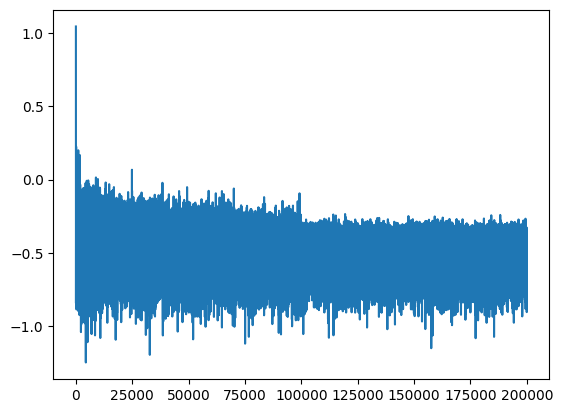

In [40]:
plt.plot(stepi, lossi)

In [41]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, input_n*3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(0.3146, grad_fn=<NllLossBackward0>)

In [42]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, input_n*3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(0.3136, grad_fn=<NllLossBackward0>)

KeyError: 3

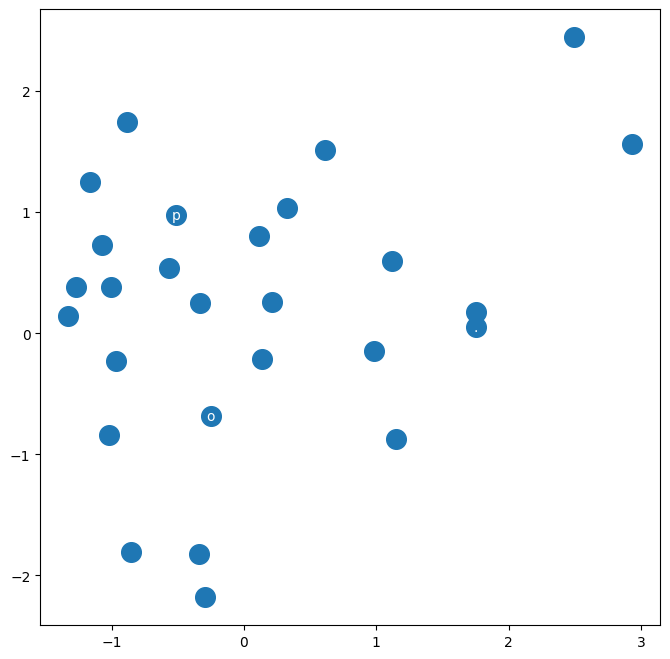

In [43]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

poooop.
pooop.
poooppooop.
poooppoooppooooppooop.
poooop.
pooop.
pooop.
poooppooop.
pooooppooooop.
pooop.
pooop.
pooop.
pooop.
poooooppooop.
pooooppooooooppoooop.
pooop.
poooppoooppoooop.
pooooppoooppooooooppooop.
pooooop.
pooop.
